## PYFEMM  


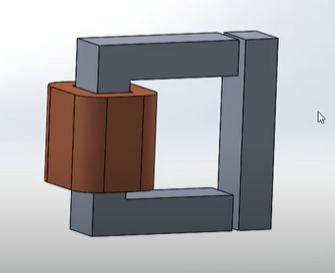  

计算C 形钢与I 型钢间的磁通随距离的变化。参数见代码。  

### 项目初始化  
通过COM 组件调用FEMM 本质上是通过命令行模拟人工操作，并不像调用dll 函数一样便捷，因为需要记录每一步的操作和整个项目的状态。

In [42]:
import abc
from typing import List, Tuple
import femm
from enum import Enum

class FemmBase(object):  
    """
    元数据的定义
    """
    cmdIn = ['mi', 'ei', 'hi', 'ci']  
    cmdOut = ['mo', 'eo', 'ho', 'co']
    pass

class Project(FemmBase):  
    pass

# 类型定义  
class DocumentType(Enum):
    """
    项目的类型
    """
    Magnetics = 0  
    Electrostatics = 1  
    HeatFlow = 2  
    CurrentFlow = 3

class Material(object):  
    """
    材料类
    """
    pass


class Area(FemmBase):
    """
    区域基类
    """
    def __init__(self,docType:DocumentType=None, material:Material = None) -> None:
        super().__init__()
        self.docType = docType
        self.material = material


    def addNode(self,point:Tuple[float,float]= (.0,.0)):
        fn = getattr(femm, "%s_addnode"%(self.cmdIn[self.docType.value]))
        fn(point[0],point[1])

    def addSegment(self,start=(.0,.0),end=(.0,.0)):
        """
        绘制一条直线
        参数说明:  
           - start(x,y) 起点的坐标  
           - end(x,y) 重点的坐标
        """
        fn = getattr(femm, "%s_addsegment"%(self.cmdIn[self.docType.value]))
        fn(start[0],start[1],end[0],end[1])
        
    @abc.abstractmethod
    def drawNodes(self):
        pass

    @abc.abstractmethod  
    def drawSegments(self):
        pass

    @abc.abstractmethod  
    def setMaterial(self):  
        pass


class PolygonArea(Area):  
    """多边形区域"""  
    def __init__(self, docType: DocumentType = None, material: Material = None, points:List[Tuple[float,float]]=[(.0,.0)]) -> None:
        super().__init__(docType, material)
        self.points = points

    def drawNodes(self):
        for point in self.points:  
            self.addNode(point)
        return self
    
    def drawSegments(self):
        for i in range(len(self.points)):
            self.addSegment(self.points[i-1],self.points[i])
        return self

class RectArea(Area):  
    """
    矩形区域
    """
    def __init__(self, docType:DocumentType=None, offsetX=.0, offsetY=.0, width=.0, height=.0, material:Material = None ) -> None:
        super().__init__(docType,material)
        self.offsetX = offsetX  
        self.offsetY = offsetY  
        self.width = width  
        self.height = height

    def drawNodes(self):  
        self.addNode(self.offsetX, self.offsetY)
        self.addNode(self.offsetX+self.width, self.offsetY)
        self.addNode(self.offsetX+self.width, self.offsetY+self.height)
        self.addNode(self.offsetX, self.offsetY+self.height)
        return self

    def drawSegments(self):
        self.addSegment(start=(self.offsetX, self.offsetY),end=(self.offsetX+self.width, self.offsetY))
        self.addSegment(start=(self.offsetX+self.width, self.offsetY),end=(self.offsetX+self.width, self.offsetY+self.height))
        self.addSegment(start=(self.offsetX+self.width, self.offsetY+self.height),end=(self.offsetX, self.offsetY+self.height))
        self.addSegment(start=(self.offsetX, self.offsetY+self.height),end=(self.offsetX, self.offsetY))
        return self
        



In [28]:
## 几何形状参数（单位：cm）  

## 硅钢：
iron_C = { 'offsetX':0, 'offsetY': 0,'width': 80, 'height':80,'innerWidth': 50, 'depth': 15 }
air_gap = 3  # 气隙距离  
boundary = {"w": 200, "h":200}


In [43]:
import femm  
# femm 4.2 在matlab 中共有600 多个函数  
# 其中根据名称可以分为：  
#   - 软件和文档的操作  
#   - mi_ 和mo_ 磁场输入输出指令  
#   - ei_ 和eo_ 电场输入输出指令  
#   - ci_ 和co_ 电路输入输出指令  
#   - hi_ 和ho_ 热

# 打开FEMM  
femm.openfemm()  

# 创建磁场分析的文档，可惜不能直接使用枚举类型
femm.newdocument(DocumentType.Magnetics.value)


PolygonArea(DocumentType.Magnetics,points=[(.0,.0),(1,0),(1,1),(0,1)]).drawNodes().drawSegments()

## 数据持久化

In [1]:
import pickle

class Address:
    def __init__(self, street, city, zip_code):
        self.street = street
        self.city = city
        self.zip_code = zip_code

class Person:
    def __init__(self, name, age, address):
        self.name = name
        self.age = age
        self.address = address

    def say_hello(self):
        print(f"Hello, my name is {self.name}. I live at {self.address.street} in {self.address.city}.")

address = Address("123 Main St", "New York", "10001")
person = Person("Alice", 25, address)

# 定义一个函数，用于将Person对象保存到文件中
def save_person(person_obj, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(person_obj, f)

# 定义一个函数，用于从文件中读取Person对象
def load_person(file_path):
    with open(file_path, "rb") as f:
        person_obj = pickle.load(f)
    return person_obj

# 保存Person对象到文件中
save_person(person, "person.pkl")

# 从文件中加载Person对象，并调用其方法
person_obj = load_person("person.pkl")
person_obj.say_hello()   # 输出：Hello, my name is Alice. I live at 123 Main St in New York.

Hello, my name is Alice. I live at 123 Main St in New York.
